# Python: Impact of 401(k) on Financial Wealth (Quantile Effects)

In this real-data example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate the effect of 401(k) eligibility and participation on accumulated assets. The 401(k) data set has been analyzed in several studies, among others [Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060), see [Kallus et al. (2019)](https://arxiv.org/abs/1912.12945) for quantile effects.

_Remark:_
_This notebook focuses on the evaluation of the treatment effect at different quantiles. For a basic introduction to the [DoubleML](https://docs.doubleml.org/stable/index.html) package and a detailed example of the average treatment effect estimation for the 401(k) data set, we refer to the notebook [Python: Impact of 401(k) on Financial Wealth](https://docs.doubleml.org/stable/examples/py_double_ml_pension.html). The Data sections of both notebooks coincide._

401(k) plans are pension accounts sponsored by employers. The key problem in determining the effect of participation in 401(k) plans on accumulated assets is saver heterogeneity coupled with the fact that the decision to enroll in a 401(k) is non-random. It is generally recognized that some people have a higher preference for saving than others. It also seems likely that those individuals with high unobserved preference for saving would be most likely to choose to participate in tax-advantaged retirement savings plans and would tend to have otherwise high amounts of accumulated assets. The presence of unobserved savings preferences with these properties then implies that conventional estimates that do not account for saver heterogeneity and endogeneity of participation will be biased upward, tending to overstate the savings effects of 401(k) participation.

One can argue that eligibility for enrolling in a 401(k) plan in this data can be taken as exogenous after conditioning on a few observables of which the most important for their argument is income. The basic idea is that, at least around the time 401(k)’s initially became available, people were unlikely to be basing their employment decisions on whether an employer offered a 401(k) but would instead focus on income and other aspects of the job.

## Data

The preprocessed data can be fetched by calling [fetch_401K()](https://docs.doubleml.org/stable/api/generated/doubleml.datasets.fetch_401K.html#doubleml.datasets.fetch_401K). Note that an internet connection is required for loading the data.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing
from doubleml.datasets import fetch_401K

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()
colors = sns.color_palette()

In [3]:
plt.rcParams['figure.figsize'] = 10., 7.5
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'axes.spines.top': False,
                            'axes.spines.bottom': False,
                            'axes.spines.left': False,
                            'axes.spines.right': False})

In [4]:
data = fetch_401K(return_type='DataFrame')

In [5]:
data.describe()

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
count,9.915000e+03,9.915000e+03,9.915000e+03,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000
mean,1.392864e+04,1.805153e+04,6.381685e+04,41.060212,37200.621094,2.865860,13.206253,0.271004,0.604841,0.380837,0.371357,0.261624,0.242158,0.635199
std,5.490488e+04,6.352250e+04,1.115297e+05,10.344505,24774.289062,1.538937,2.810382,0.444500,0.488909,0.485617,0.483192,0.439541,0.428411,0.481399
min,0.000000e+00,-5.023020e+05,-5.023020e+05,25.000000,-2652.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+02,-5.000000e+02,3.291500e+03,32.000000,19413.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.635000e+03,1.499000e+03,2.510000e+04,40.000000,31476.000000,3.000000,12.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,8.765500e+03,1.652450e+04,8.148750e+04,48.000000,48583.500000,4.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.430298e+06,1.536798e+06,2.029910e+06,64.000000,242124.000000,13.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The data consist of 9,915 observations at the household level drawn from the 1991 Survey of Income and Program Participation (SIPP).  All the variables are referred to 1990. We use net financial assets (*net\_tfa*) as the outcome variable, $Y$,  in our analysis. The net financial assets are computed as the sum of IRA balances, 401(k) balances, checking accounts, saving bonds, other interest-earning accounts, other interest-earning assets, stocks, and mutual funds less non mortgage debts. 

Among the $9915$ individuals, $3682$ are eligible to participate in the program. The variable *e401* indicates eligibility and *p401* indicates participation, respectively.

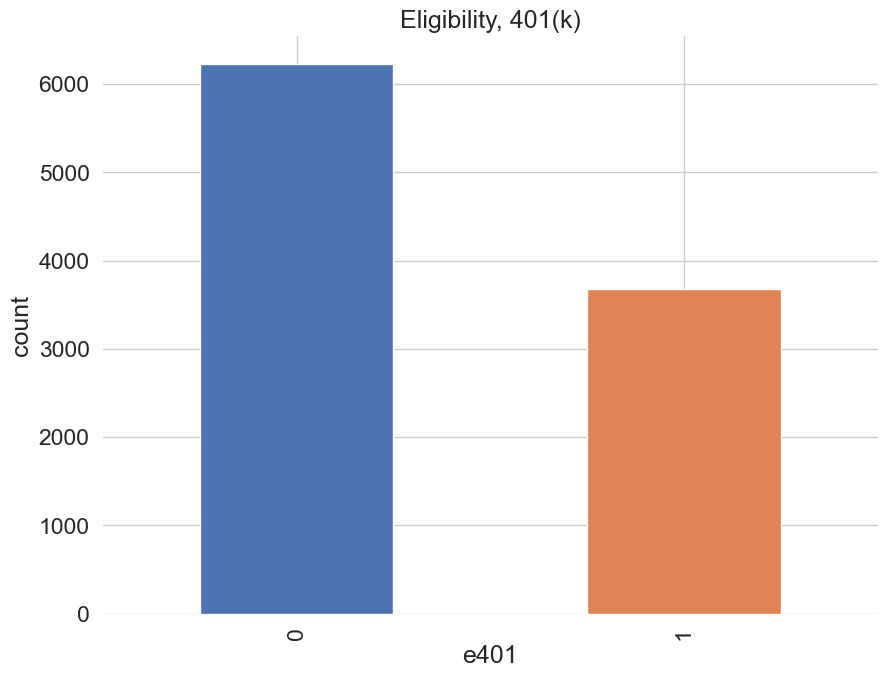

In [6]:
data['e401'].value_counts().plot(kind='bar', color=colors)
plt.title('Eligibility, 401(k)')
plt.xlabel('e401')
_ = plt.ylabel('count')

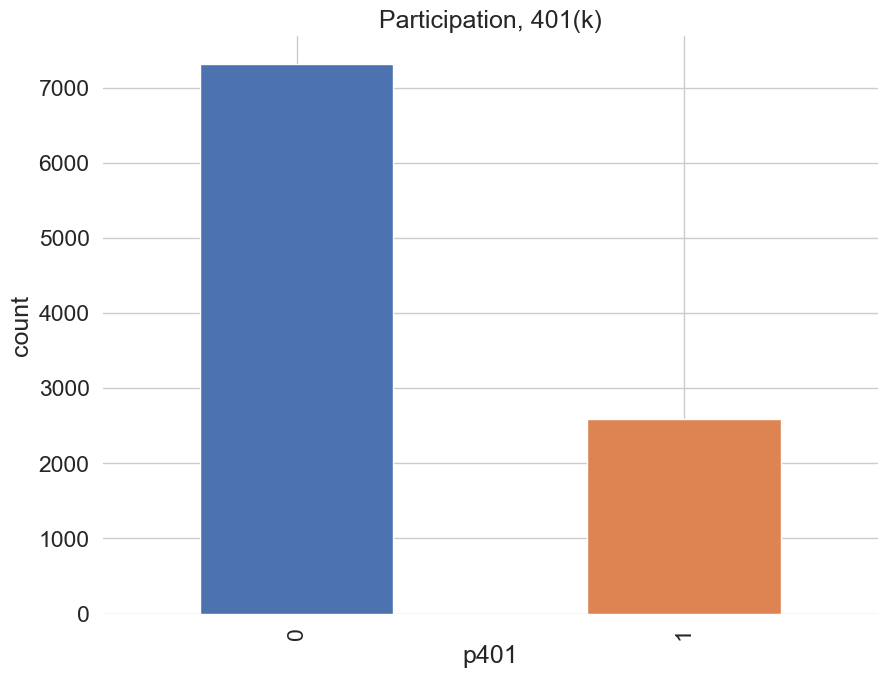

In [7]:
data['p401'].value_counts().plot(kind='bar', color=colors)
plt.title('Participation, 401(k)')
plt.xlabel('p401')
_ = plt.ylabel('count')

Eligibility is highly associated with financial wealth:

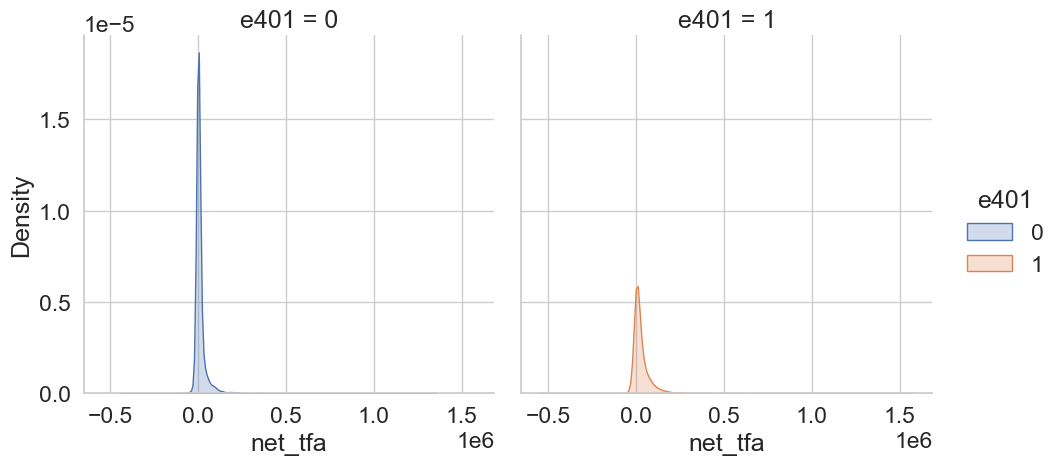

In [8]:
_ = sns.displot(data, x="net_tfa", hue="e401", col="e401",
                kind="kde", fill=True)

As a first estimate, we calculate the unconditional average predictive effect (APE) of 401(k) eligibility on accumulated assets. This effect corresponds to the average treatment effect if 401(k) eligibility would be assigned to individuals in an entirely randomized way. The unconditional APE of e401 is about $19559$:

In [9]:
data[['e401', 'net_tfa']].groupby('e401').mean().diff()

,net_tfa
e401,
0,NaN
1,19559.34375


Among the $3682$ individuals that  are eligible, $2594$ decided to participate in the program. The unconditional APE of p401 is about $27372$:

In [10]:
data[['p401', 'net_tfa']].groupby('p401').mean().diff()

,net_tfa
p401,
0,NaN
1,27371.582031


As discussed, these estimates are biased since they do not account for saver heterogeneity and endogeneity of participation.

In [11]:
# Set up basic model: Specify variables for data-backend
features_base = ['age', 'inc', 'educ', 'fsize', 'marr',
                 'twoearn', 'db', 'pira', 'hown']


# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_base = dml.DoubleMLData(data,
                                 y_col='net_tfa',
                                 d_cols='e401',
                                 x_cols=features_base)

## Estimating Potential Quantiles and Quantile Treatment Effects

We will use the [DoubleML](https://docs.doubleml.org/stable/index.html) package to estimate quantile treatment effects of 401(k) eligibility, i.e. `e401`.
As it is more interesting to take a look at a range of quantiles instead of a single one, we will first define a discretisized grid of quanitles `tau_vec`, which will range from the 10%-quantile to the 90%-quantile.
Further, we need a machine learning algorithm to estimate the nuisance elements of our model. In this example, we will use a basic `RandomForestClassifier`.

In [12]:
tau_vec = np.arange(0.1,0.95,0.05)
n_folds = 5

# Random Forest
learner = RandomForestClassifier(
    n_estimators=100, max_depth=20, max_features=5, min_samples_leaf=10)

Next, we will apply create an `DoubleMLPQ` object for each quantile to fit a quantile model. Here, we have to specifiy, whether we would like to estimate a potential quantile for the treatment group `treatment=1` or control `treatment=0`. Further basic options are trimming and normalization of the propensity scores (`trimming_rule="truncate"`, `trimming_threshold=0.01` and `normalize_ipw=True`). 

In [ ]:
PQ_0 = np.full((len(tau_vec)), np.nan)
PQ_1 = np.full((len(tau_vec)), np.nan)

ci_PQ_0 = np.full((len(tau_vec),2), np.nan)
ci_PQ_1 = np.full((len(tau_vec),2), np.nan)

for idx_tau, tau in enumerate(tau_vec):
    print(f'Quantile: {tau}')
    dml_PQ_0 = dml.DoubleMLPQ(data_dml_base, 
                              ml_g=clone(learner),
                              ml_m=clone(learner),
                              score="PQ",
                              treatment=0,
                              quantile=tau,
                              n_folds=n_folds,
                              normalize_ipw=True,
                              trimming_rule="truncate",
                              trimming_threshold=1e-2)
    dml_PQ_1 = dml.DoubleMLPQ(data_dml_base,
                              ml_g=clone(learner),
                              ml_m=clone(learner),
                              score="PQ",
                              treatment=1,
                              quantile=tau,
                              n_folds=n_folds,
                              normalize_ipw=True,
                              trimming_rule="truncate",
                              trimming_threshold=1e-2)

    dml_PQ_0.fit()
    dml_PQ_1.fit()

    PQ_0[idx_tau] = dml_PQ_0.coef
    PQ_1[idx_tau] = dml_PQ_1.coef

    ci_PQ_0[idx_tau, :] = dml_PQ_0.confint(level=0.95).to_numpy()
    ci_PQ_1[idx_tau, :] = dml_PQ_1.confint(level=0.95).to_numpy()

Additionally, each `DoubleMLPQ` object has a (hopefully) helpful summary, which indicates also the evaluation of the nuisance elements with cross-validated estimation. See e.g. `dml_PQ_1'

In [ ]:
print(dml_PQ_1)

Finally, let us take a look at the estimated potential quantiles

In [ ]:
data_pq = {"Quantile": tau_vec,
           "DML Y(0)": PQ_0, "DML Y(1)": PQ_1,
           "DML Y(0) lower": ci_PQ_0[:, 0], "DML Y(0) upper": ci_PQ_0[:, 1],
           "DML Y(1) lower": ci_PQ_1[:, 0], "DML Y(1) upper": ci_PQ_1[:, 1]}
df_pq = pd.DataFrame(data_pq)
print(df_pq)

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5
fig, (ax1, ax2) = plt.subplots(1 ,2)
ax1.grid(); ax2.grid()

ax1.plot(df_pq['Quantile'],df_pq['DML Y(0)'], color='violet', label='Estimated Quantile Y(0)')
ax1.fill_between(df_pq['Quantile'], df_pq['DML Y(0) lower'], df_pq['DML Y(0) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax1.legend()

ax2.plot(df_pq['Quantile'],df_pq['DML Y(1)'], color='violet', label='Estimated Quantile Y(1)')
ax2.fill_between(df_pq['Quantile'], df_pq['DML Y(1) lower'], df_pq['DML Y(1) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax2.legend()

fig.suptitle('Potential Quantiles', fontsize=16)
fig.supxlabel('Quantile')
_ = fig.supylabel('Potential Quantile and 95%-CI')

As we are interested in the QTE, we can use the `DoubleMLQTE` object, which internally fits two `DoubleMLPQ` objects for the treatment and control group. The main advantage is to apply this to a list of quantiles and construct uniformly valid confidence intervals for the range of treatment effects.

In [13]:
n_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {n_cores}")

np.random.seed(42)
dml_QTE = dml.DoubleMLQTE(data_dml_base,
                           ml_g=clone(learner),
                           ml_m=clone(learner),
                           quantiles=tau_vec,
                           score='PQ',
                           n_folds=n_folds,
                           normalize_ipw=True,
                           trimming_rule="truncate",
                           trimming_threshold=1e-2)
dml_QTE.fit(n_jobs_models=n_cores-1)
print(dml_QTE)

================== DoubleMLQTE Object ==================

------------------ Fit summary       ------------------
         coef      std err          t         P>|t|         2.5 %  \
0.10   1601.0   366.085743   4.373292  1.223866e-05    883.485129   
0.15   1200.0   249.486286   4.809884  1.510182e-06    711.015865   
0.20   1224.0   234.882351   5.211120  1.877045e-07    763.639052   
0.25   1000.0   220.889223   4.527156  5.978277e-06    567.065078   
0.30    649.0   235.553813   2.755209  5.865464e-03    187.323011   
0.35    900.0   225.867729   3.984633  6.758450e-05    457.307386   
0.40   1620.0   231.441395   6.999612  2.566721e-12   1166.383201   
0.45   2900.0   299.965109   9.667791  4.132001e-22   2312.079190   
0.50   4126.0   374.671241  11.012321  3.333045e-28   3391.657862   
0.55   4945.0   434.728388  11.374919  5.575489e-30   4092.948016   
0.60   6760.0   643.137694  10.510968  7.689978e-26   5499.473282   
0.65   8600.0   799.986578  10.750180  5.914585e-27   7032

For uniformly valid confidence intervals, we still need to apply a bootstrap first. 
Let's take a quick look at the QTEs combinded with a confidence interval.

In [17]:
dml_QTE.bootstrap(n_rep_boot=2000)
ci_QTE = dml_QTE.confint(level=0.95, joint=True)

data_qte = {"Quantile": tau_vec, "DML QTE": dml_QTE.coef,
            "DML QTE lower": ci_QTE["2.5 %"], "DML QTE upper": ci_QTE["97.5 %"]}
df_qte = pd.DataFrame(data_qte)
print(df_qte)

      Quantile  DML QTE  DML QTE lower  DML QTE upper
0.10      0.10   1601.0     555.486637    2646.513363
0.15      0.15   1200.0     487.485921    1912.514079
0.20      0.20   1224.0     553.193662    1894.806338
0.25      0.25   1000.0     369.156983    1630.843017
0.30      0.30    649.0     -23.723982    1321.723982
0.35      0.35    900.0     254.938745    1545.061255
0.40      0.40   1620.0     959.020773    2280.979227
0.45      0.45   2900.0    2043.322197    3756.677803
0.50      0.50   4126.0    3055.967101    5196.032899
0.55      0.55   4945.0    3703.448402    6186.551598
0.60      0.60   6760.0    4923.247090    8596.752910
0.65      0.65   8600.0    6315.298470   10884.701530
0.70      0.70  10621.0    7718.916034   13523.083966
0.75      0.75  13084.0    9775.770725   16392.229275
0.80      0.80  15500.0   10885.710670   20114.289330
0.85      0.85  18500.0   13822.314616   23177.685384
0.90      0.90  20270.0   13870.408859   26669.591141


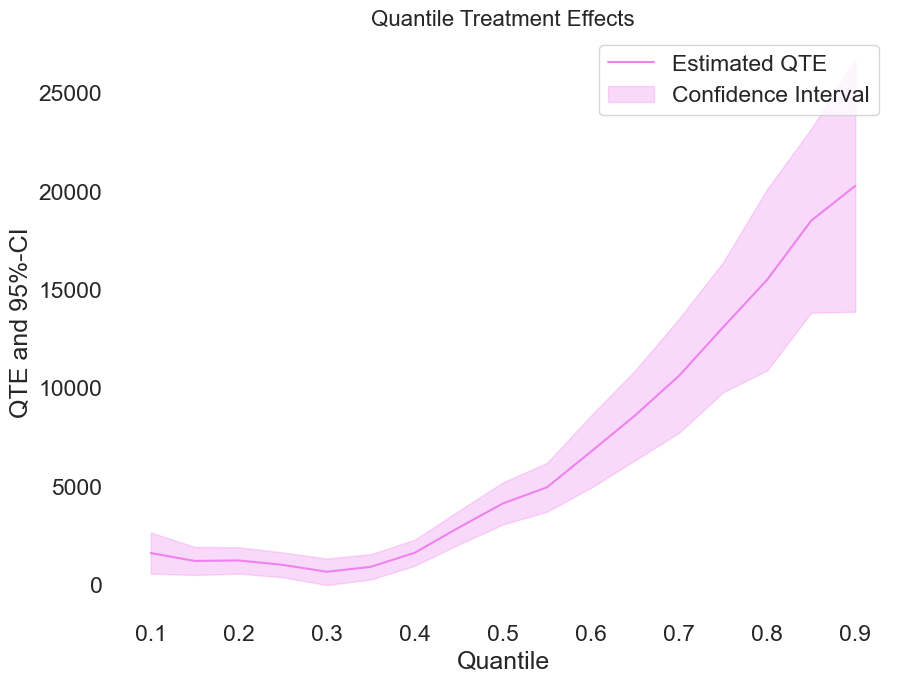

In [18]:
plt.rcParams['figure.figsize'] = 10., 7.5
fig, ax = plt.subplots()
ax.grid()

ax.plot(df_qte['Quantile'],df_qte['DML QTE'], color='violet', label='Estimated QTE')
ax.fill_between(df_qte['Quantile'], df_qte['DML QTE lower'], df_qte['DML QTE upper'], color='violet', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('Quantile Treatment Effects', fontsize=16)
plt.xlabel('Quantile')
_ = plt.ylabel('QTE and 95%-CI')

## Estimating the treatment effect on the Conditional Value a Risk (CVaR)

Similar to the evaluation of the estimation of quantile treatment effects (QTEs), we can estimate the conditional value at risk ([CVaR](https://de.wikipedia.org/wiki/Conditional_Value_at_Risk)) for given quantiles. Here, we will only focus on treatment effect estimation, but the DoubleML package also allows for estimation of potential CVaRs.

The estimation of treatment effects can be easily done by adjusting the score in the `DoubleMLQTE` object to `score="CVaR"`, as the estimation is based on the same nuisance elements as QTEs.

In [ ]:
np.random.seed(42)
dml_CVAR = dml.DoubleMLQTE(data_dml_base,
                           ml_g=clone(learner),
                           ml_m=clone(learner),
                           quantiles=tau_vec,
                           score="CVaR",
                           n_folds=n_folds,
                           normalize_ipw=True,
                           trimming_rule="truncate",
                           trimming_threshold=1e-2)
dml_CVAR.fit()
print(dml_CVAR)

Estimation of the corresponding (uniformly) valid confidence intervals can be done analogously to the quantile treatment effects.

In [ ]:
dml_CVAR.bootstrap(n_rep_boot=2000)
ci_CVAR = dml_CVAR.confint(level=0.95, joint=True)

data_cvar = {"Quantile": tau_vec, "DML CVAR": dml_CVAR.coef,
            "DML CVAR lower": ci_CVAR["2.5 %"], "DML CVAR upper": ci_CVAR["97.5 %"]}
df_cvar = pd.DataFrame(data_cvar)
print(df_cvar)

Finally, let us take a look at the estimated treatment effects on the CVaR.

In [ ]:
plt.rcParams['figure.figsize'] = 10., 7.5
fig, ax = plt.subplots()
ax.grid()

ax.plot(df_cvar['Quantile'],df_cvar['DML CVAR'], color='violet', label='Estimated CVaR Effect')
ax.fill_between(df_cvar['Quantile'], df_cvar['DML CVAR lower'], df_cvar['DML CVAR upper'], color='violet', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('Conditional Value at Risk', fontsize=16)
plt.xlabel('Quantile')
_ = plt.ylabel('CVaR Effect and 95%-CI')

## Estimating local quantile treatment effects (LQTEs)

If we have an `IIVM` model with a given instrumental variable, we are still able to identify the local quantile treatment effect (LQTE), the quantile treatment effect on compliers. For the 401(k) pension data we can use `e401` as an instrument for participation `p401`. 
To fit an `DoubleML` model with an instrument, we have to change the data backend and specify the instrument.

In [ ]:
# Initialize DoubleMLData with an instrument

# Basic model
data_dml_base_iv = dml.DoubleMLData(data,
                                    y_col='net_tfa',
                                    d_cols='p401',
                                    z_cols='e401',
                                    x_cols=features_base)

print(data_dml_base_iv)

The estimation of local treatment effects can be easily done by adjusting the score in the `DoubleMLQTE` object to `score="LPQ"`.

In [ ]:
np.random.seed(42)
dml_LQTE = dml.DoubleMLQTE(data_dml_base_iv,
                           ml_g=clone(learner),
                           ml_m=clone(learner),
                           quantiles=tau_vec,
                           score="LPQ",
                           n_folds=n_folds,
                           normalize_ipw=True,
                           trimming_rule="truncate",
                           trimming_threshold=1e-2)
dml_LQTE.fit()
print(dml_LQTE)

Estimation of the corresponding (uniformly) valid confidence intervals can be done analogously to the quantile treatment effects.

In [ ]:
dml_LQTE.bootstrap(n_rep_boot=2000)
ci_LQTE = dml_LQTE.confint(level=0.95, joint=True)

data_lqte = {"Quantile": tau_vec, "DML LQTE": dml_LQTE.coef,
            "DML LQTE lower": ci_LQTE["2.5 %"], "DML LQTE upper": ci_LQTE["97.5 %"]}
df_lqte = pd.DataFrame(data_lqte)
print(df_lqte)

Finally, let us take a look at the estimated local quantile treatment effects.

In [ ]:
plt.rcParams['figure.figsize'] = 10., 7.5
fig, ax = plt.subplots()
ax.grid()

ax.plot(df_lqte['Quantile'],df_lqte['DML LQTE'], color='violet', label='Estimated LQTE')
ax.fill_between(df_lqte['Quantile'], df_lqte['DML LQTE lower'], df_lqte['DML LQTE upper'], color='violet', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('Local Quantile Treatment Effect', fontsize=16)
plt.xlabel('Quantile')
_ = plt.ylabel('LQTE and 95%-CI')